### Try the network sampler

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bayes_coloc.continuous_donut_interaction import DonutInteraction
from bayes_coloc.plot_matching_lines import plot_pair_prob


%load_ext autoreload
%autoreload 2

In [2]:
np.random.seed(10)

d = 2

# set parameters
area = 1
scale = 0.02
radius = 0.04
lam_gamma = 10
lam_mu = 5
lam_nu = 7
true_params = {'lam_gamma': lam_gamma, 'lam_mu': lam_mu, 'lam_nu': lam_nu,
    'scale': scale, 'radius': radius, 'area': area}

### Data generation 

n_gamma = np.random.poisson(lam=true_params['lam_gamma']*area)
n_mu = np.random.poisson(lam=true_params['lam_mu']*area)
n_nu = np.random.poisson(lam=true_params['lam_nu']*area)

# Sample points in space 
hatmu = np.random.random(size=(n_mu, d)) 
hatnu = np.random.random(size=(n_nu, d)) 
hatgamma_x = np.random.random(size=(n_gamma, d))
random_angles = 2*np.pi*np.random.random(size=n_gamma)
random_directions = np.vstack((np.cos(random_angles), np.sin(random_angles))).T
random_shift = random_directions * radius
hatgamma_y = hatgamma_x + np.random.normal(scale=scale, size=(n_gamma, d)) + random_shift

# Merge marginals
x = np.vstack((hatgamma_x, hatmu))
y = np.vstack((hatgamma_y, hatnu))

nx, ny = len(x), len(y)

# now shuffle the data
perm_x = np.random.permutation(nx)
perm_y = np.random.permutation(ny)
x = x[perm_x]
y = y[perm_y]

# COMPUTE (TRUE) MATCHING
unpermuted_matching_mat = np.zeros((nx, ny))
unpermuted_matching_mat[range(n_gamma), range(n_gamma)] = 1
matching_mat = unpermuted_matching_mat[:, perm_y]
matching_mat = matching_mat[perm_x, :]



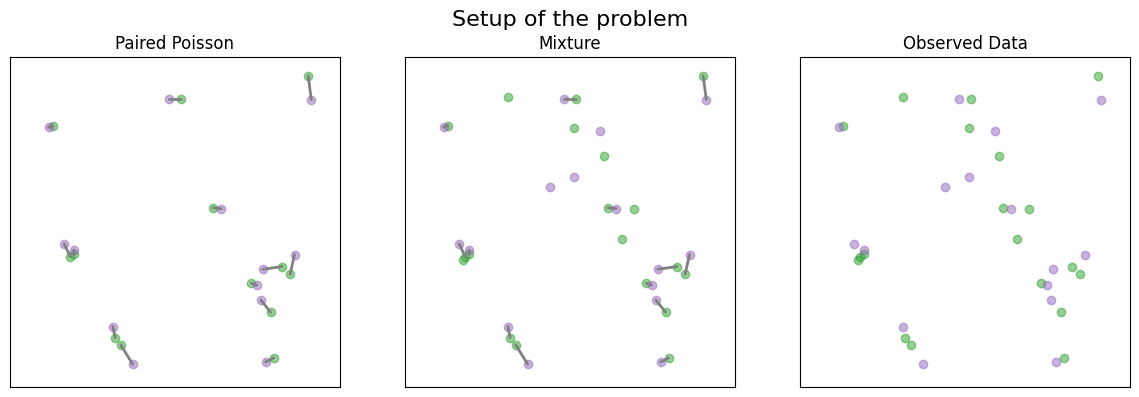

In [3]:
fig, axis = plt.subplots(ncols=3, figsize=(12, 4))
marker = "o"
alpha = 0.5
linewidth = 2
plan = np.eye(len(hatgamma_y))
plot_pair_prob(hatgamma_x, hatgamma_y, plan, l=linewidth, 
               ax=axis[0], scatter_alpha=alpha)
axis[0].set_aspect("equal")
h = 0.05

axis[0].set_title("Paired Poisson")
axis[1].set_title("Mixture")
axis[2].set_title("Observed Data")

for ax in axis:
    ax.set_aspect("equal")
    ax.set_xlim(-h, np.sqrt(area)+h)
    ax.set_ylim(-h, np.sqrt(area)+h)
    # remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
plot_pair_prob(x, y, matching_mat, ax=axis[1], l=linewidth, scatter_alpha=alpha)
no_matching = np.zeros((nx, ny))
plot_pair_prob(x, y, no_matching, ax=axis[2], l=linewidth, scatter_alpha=alpha)
axis[1].set_title("Mixture")
axis[2].set_title("Observed Data")
fig.suptitle("Setup of the problem", fontsize=16)
# thight layout
plt.tight_layout()
# plt.savefig("setup_plot_v2.pdf")
plt.show()


In [4]:
# print relevant data
print("lambda gamma: ", lam_gamma, "lambda mu: ", lam_mu, "lambda nu: ", lam_nu)
print("Number of pairs: ", n_gamma, "Number of single A: ", n_mu, "Number of single B: ", n_nu)
print("Number of points in x: ", nx, "Number of points in y: ", ny)
print("Standard deviation", scale)
print("Radius: ", radius)

lambda gamma:  10 lambda mu:  5 lambda nu:  7
Number of pairs:  13 Number of single A:  6 Number of single B:  3
Number of points in x:  19 Number of points in y:  16
Standard deviation 0.02
Radius:  0.04


In [ ]:
# define proposal, prior and starting parameters
scale_interval = [0., 0.05]
radius_interval = [0, 0.05  ]

area = 1
hyper_theta = len(x)/2


    
def log_prior(params):
    """ Defines a log prior for the parameters of the model (up to a constant)"""
    
    lam_mu = params["lam_mu"]
    lam_gamma = params['lam_gamma']
    lam_nu = params["lam_nu"]
    radius = params['radius']
    scale = params['scale']
    
    # hyperparameters
    k = 1
    theta = hyper_theta
    def ld_gamma(x, k, theta):  
        a = k
        b = 1/theta
        if x <= 0:
            return -np.inf
        else:
            return a*np.log(b) - gammaln(a) + (a-1)*np.log(x) - b*x


    # check if lam parameters are valid
    log_prob = 0
    
    log_prob += ld_gamma(lam_mu, k, theta)
    log_prob += ld_gamma(lam_gamma, k, theta)
    log_prob += ld_gamma(lam_nu, k, theta)
    
    if scale_interval[0] < scale < scale_interval[1]:
        log_prob += 0
    else:
        log_prob = -np.inf
    if radius_interval[0] < radius < radius_interval[1]:
        log_prob += 0
    else:
        log_prob = -np.inf
    return log_prob

def proposal(params):
    """ Defines a proposal for the parameters of the model """
    scale_temp = 0.1
    radius_temp = 0.1
    intensity_temp = 2
    
    scale = params['scale']
    radius = params['radius']
    lam_mu = params["lam_mu"]
    lam_gamma = params['lam_gamma']
    lam_nu = params["lam_nu"]
    
    # new proposal for the scale
    scale_new = scale + np.random.normal(scale=scale_temp)
    new_radius = radius + np.random.normal(scale=radius_temp)
    
    # new proposal for the intensities
    lam_mu_new = lam_mu + np.random.normal(scale=intensity_temp)
    lam_nu_new = lam_nu + np.random.normal(scale=intensity_temp)
    lam_gamma_new = lam_gamma + np.random.normal(scale=intensity_temp)
    
    return {"lam_mu": lam_mu_new, "lam_nu": lam_nu_new, "lam_gamma": lam_gamma_new, "scale": scale_new, "radius":new_radius, "area":area}


start_params = {"lam_mu": hyper_theta, "lam_nu": hyper_theta, "lam_gamma": hyper_theta,
                "scale": 2, "radius":2, "area":area}





In [27]:
np.random.seed(1)
print(len(x), len(y))

chain = DonutInteraction(x, y, start_param=start_params, proposal=proposal, log_prior=log_prior)

98 88


In [28]:
chain.run(n_samples=100000, burn_in=0)
print(len(chain.param_trajectory))

Burn-in period: 0it [00:00, ?it/s]
Sampling:   0%|          | 39/100000 [00:00<08:32, 194.93it/s]/home/nies1/pair-count/poisson_model/bayes_coloc/continuous_donut_interaction.py:90: RuntimeWarning: invalid value encountered in log
  lxy += ln(lam_gamma)
/home/nies1/serpe/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
Sampling:  52%|█████▏    | 52205/100000 [05:28<03:30, 226.69it/s]/home/nies1/pair-count/poisson_model/bayes_coloc/new_proposal_mcmc.py:198: RuntimeWarning: divide by zero encountered in log
  log_acceptance_ratio += ln(reverse_swap_prob) -  ln(swap_prob)
Sampling:  52%|█████▏    | 52258/100000 [05:28<03:18, 240.95it/s]/home/nies1/pair-count/poisson_model/bayes_coloc/continuous_donut_interaction.py:78: RuntimeWarning: invalid value encountered in log
  lxy -= ln(scale)
/home/nies1/pair-count/poisson_model/bayes_coloc/continuous_donut_interaction.py:161: Runt

100001


In [29]:
chain.latent_acceptance_rate

0.06932

In [30]:
print(len(x), len(y), n_gamma)
print(n_gamma, n_mu, n_nu)

98 88 0
0 98 88


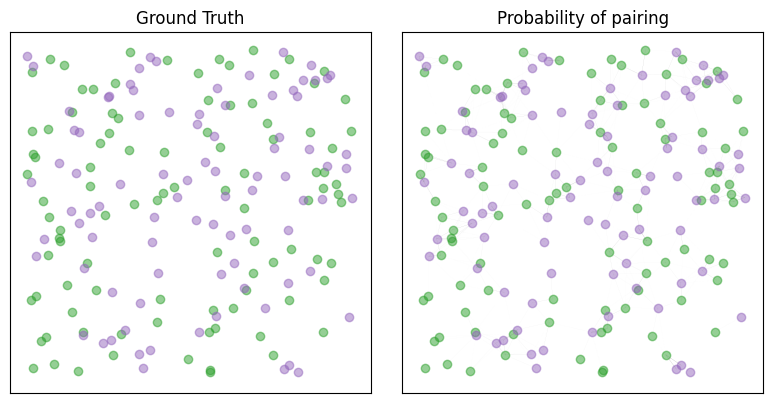

In [31]:
fig, axis = plt.subplots(ncols=2, figsize=(8, 4))
marker = "o"
alpha = 0.5
linewidth = 2
plan = np.eye(len(hatgamma_y))
plot_pair_prob(hatgamma_x, hatgamma_y, plan, l=linewidth, 
               ax=axis[0], scatter_alpha=alpha)
axis[0].set_aspect("equal")
h = 0.05



for ax in axis:
    ax.set_aspect("equal")
    ax.set_xlim(-h, 1+h)
    ax.set_ylim(-h, 1+h)
    # remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
plot_pair_prob(x, y, matching_mat, ax=axis[0], l=linewidth, scatter_alpha=alpha)
no_matching = np.zeros((nx, ny))
plot_pair_prob(x, y, chain.pairing_probabilities(), ax=axis[1], l=linewidth, scatter_alpha=alpha)
axis[0].set_title("Ground Truth")
axis[1].set_title("Probability of pairing")
# thight layout
plt.tight_layout()
# plt.savefig("setup_plot_v2.pdf")
plt.show()


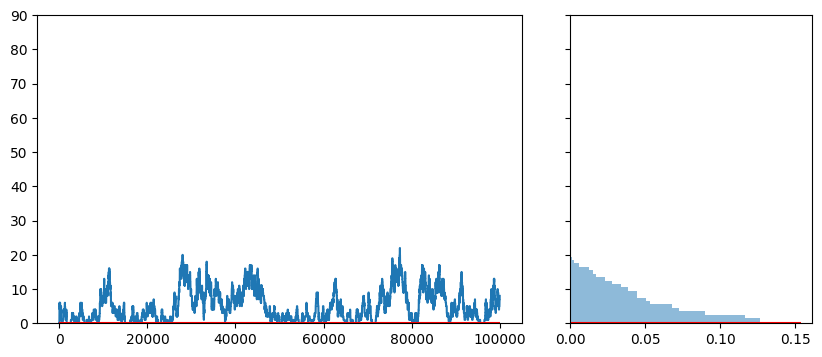

In [32]:
gridspec = dict(wspace=0.0, width_ratios=[1, 0.1, 0.5])
fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw=gridspec, figsize=(10, 4))
n_max = np.minimum(nx, ny)

ax[1].set_visible(False)

pair_count = chain.pair_count_trajectory
ax[0].plot(np.arange(len(pair_count)), pair_count)
ax[0].set_ylim((0, n_max+2))
ax[0].hlines(y=n_gamma, xmin=0, xmax=len(pair_count), color="red")
bins = np.arange(n_max+2)-0.5
ax[2].hist(chain.pair_count_trajectory, bins=bins, alpha=0.5, label="MCMC", 
           orientation="horizontal", color="tab:blue", density=True)
xmax = np.max(np.histogram(pair_count, bins=bins, density=True)[0])
ax[2].hlines(y=n_gamma, xmin=0, xmax=xmax, color="red")
ax[2].set_ylim((0, n_max+2))
ax[2].set_yticklabels([])
plt.show()



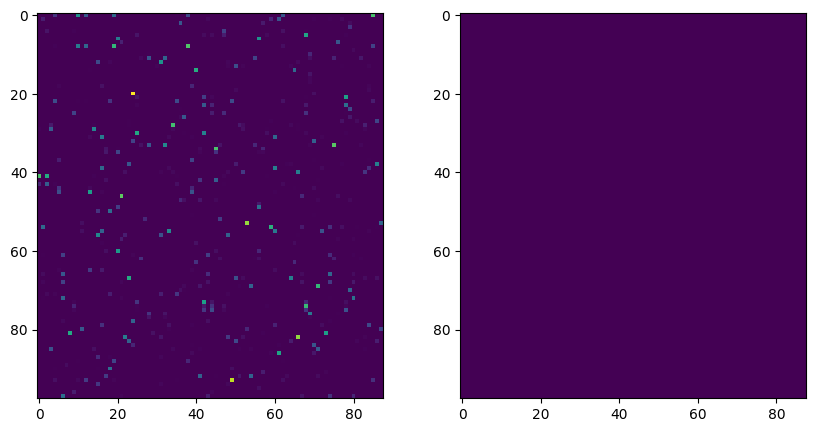

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(chain.pairing_probabilities())
ax[1].imshow(matching_mat)

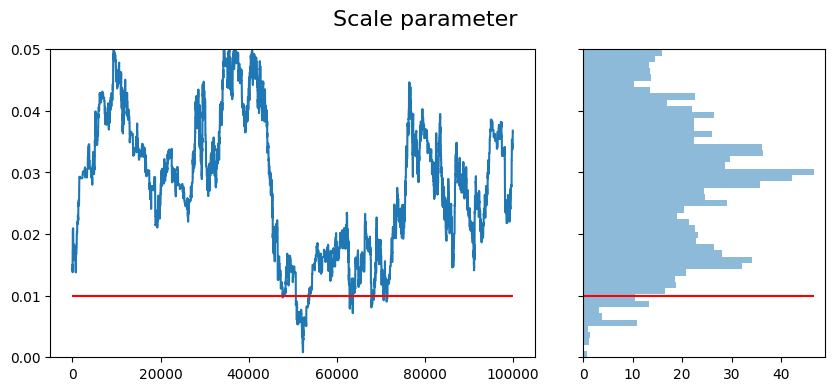

In [34]:
# scale parameter
gridspec = dict(wspace=0.0, width_ratios=[1, 0.1, 0.5])
fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw=gridspec, figsize=(10, 4))
fig.suptitle("Scale parameter", fontsize=16)
ax[0].set_ylim(scale_interval)
ax[1].set_visible(False)

scale_trajectory = [params["scale"] for params in chain.param_trajectory]
ax[0].plot(np.arange(len(scale_trajectory)), scale_trajectory)
ax[0].hlines(y=true_params["scale"], xmin=0, xmax=len(scale_trajectory), color="red")

bins = np.linspace(scale_interval[0], scale_interval[1], 50)
ax[2].hist(scale_trajectory, bins=bins, alpha=0.5, label="MCMC", 
           color="tab:blue", density=True, orientation="horizontal")
xmax = np.max(np.histogram(scale_trajectory, bins=bins, density=True)[0])
ax[2].hlines(y=true_params["scale"], xmin=0, xmax=xmax, color="red")
ax[2].set_ylim(scale_interval)
ax[2].set_yticklabels([])
plt.show()



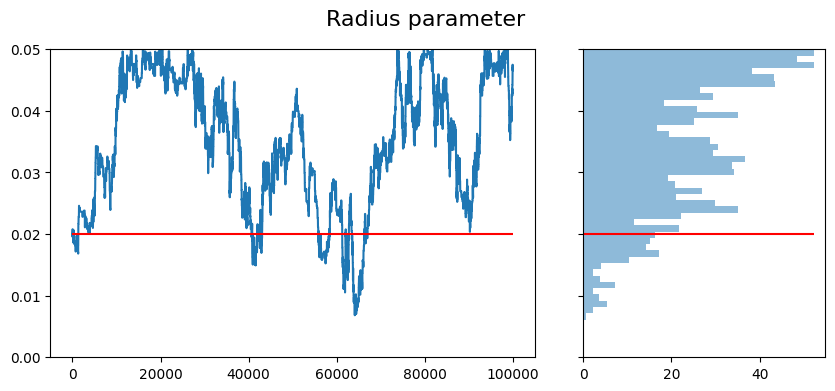

In [35]:
# do plot for radius parameter
gridspec = dict(wspace=0.0, width_ratios=[1, 0.1, 0.5])
fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw=gridspec, figsize=(10, 4))
fig.suptitle("Radius parameter", fontsize=16)
ax[0].set_ylim(radius_interval)
ax[1].set_visible(False)

radius_trajectory = [params["radius"] for params in chain.param_trajectory]
ax[0].plot(np.arange(len(radius_trajectory)), radius_trajectory)
ax[0].hlines(y=true_params["radius"], xmin=0, xmax=len(radius_trajectory), color="red")

bins = np.linspace(radius_interval[0], radius_interval[1], 50)
ax[2].hist(radius_trajectory, bins=bins, alpha=0.5, label="MCMC", 
           color="tab:blue", density=True, orientation="horizontal")
xmax = np.max(np.histogram(radius_trajectory, bins=bins, density=True)[0])
ax[2].hlines(y=true_params["radius"], xmin=0, xmax=xmax, color="red")
ax[2].set_ylim(radius_interval)
ax[2].set_yticklabels([])
plt.show()


Text(0.5, 1.0, 'Trajectory in parameter space')

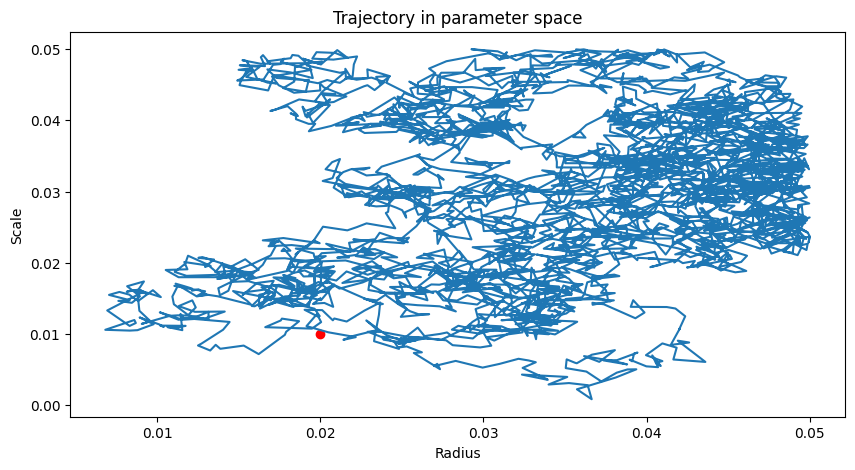

In [36]:
# plot trajectory of radius and scale in 2D
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
ax.plot(radius_trajectory, scale_trajectory)
ax.scatter([true_params["radius"]], [true_params["scale"]], color="red")
ax.set_xlabel("Radius")
ax.set_ylabel("Scale")
ax.set_title("Trajectory in parameter space")



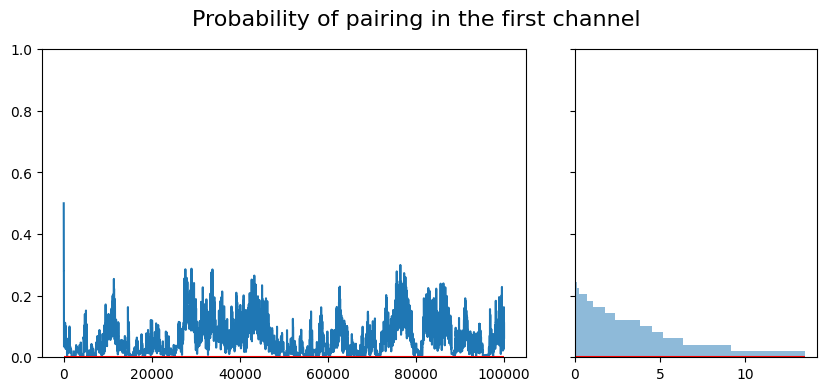

In [37]:
# Probability of A being paired with B
gridspec = dict(wspace=0.0, width_ratios=[1, 0.1, 0.5])
fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw=gridspec, figsize=(10, 4))
fig.suptitle("Probability of pairing in the first channel", fontsize=16)
ax[0].set_ylim((0, 1))

ax[1].set_visible(False)
p_a_paired_traj = [params["lam_gamma"]/(params["lam_gamma"]+params["lam_mu"]) for params in chain.param_trajectory]
p_a_paired_true = true_params["lam_gamma"]/(true_params["lam_gamma"] + true_params["lam_mu"])
ax[0].plot(np.arange(len(p_a_paired_traj)), p_a_paired_traj)
ax[0].hlines(y=p_a_paired_true, xmin=0, xmax=len(p_a_paired_traj), color="red")

bins = np.linspace(0, 1, 50)
ax[2].hist(p_a_paired_traj, bins=bins, alpha=0.5, label="MCMC", 
           color="tab:blue", density=True, orientation="horizontal")
xmax = np.max(np.histogram(p_a_paired_traj, bins=bins, density=True)[0])
ax[2].hlines(y=p_a_paired_true, xmin=0, xmax=xmax, color="red")
ax[2].set_ylim((0, 1))
ax[2].set_yticklabels([])
plt.show()

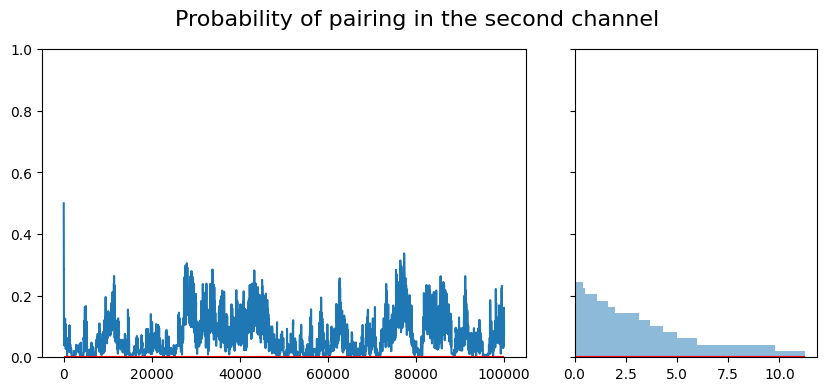

In [38]:
# probability of pairing in the second channel
gridspec = dict(wspace=0.0, width_ratios=[1, 0.1, 0.5])
fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw=gridspec, figsize=(10, 4))
fig.suptitle("Probability of pairing in the second channel", fontsize=16)
ax[0].set_ylim((0, 1))

ax[1].set_visible(False)
p_b_pair_traj = [params["lam_gamma"]/(params["lam_gamma"]+params["lam_nu"]) for params in chain.param_trajectory]
p_b_pair_true = true_params["lam_gamma"]/(true_params["lam_gamma"] + true_params["lam_nu"])
ax[0].plot(np.arange(len(p_b_pair_traj)), p_b_pair_traj)
ax[0].hlines(y=p_b_pair_true, xmin=0, xmax=len(p_b_pair_traj), color="red")

bins = np.linspace(0, 1, 50)
ax[2].hist(p_b_pair_traj, bins=bins, alpha=0.5, label="MCMC", 
           color="tab:blue", density=True, orientation="horizontal")
xmax = np.max(np.histogram(p_b_pair_traj, bins=bins, density=True)[0])
ax[2].hlines(y=p_b_pair_true, xmin=0, xmax=xmax, color="red")
ax[2].set_ylim((0, 1))

ax[2].set_yticklabels([])
plt.show()



Text(0.5, 1.0, 'Trajectory in parameter space')

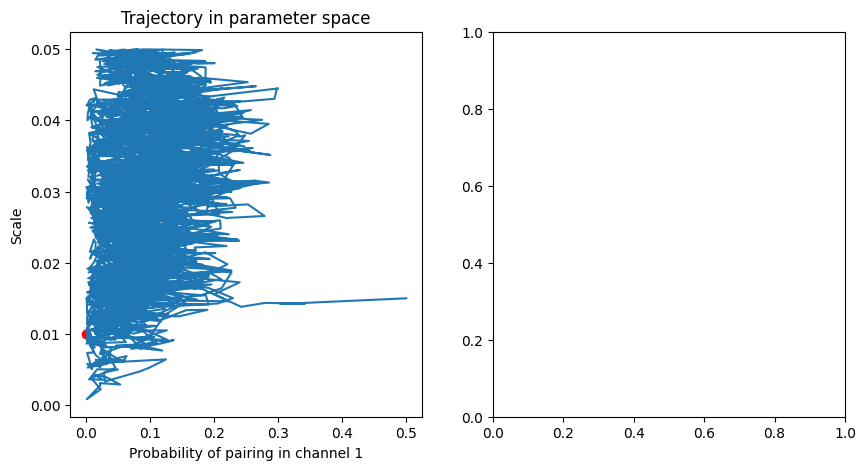

In [39]:
# plot pairing probability and standard deviation trajectory

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].plot(p_a_paired_traj, scale_trajectory)
ax[0].scatter([p_a_paired_true], [true_params["scale"]], color="red")
ax[0].set_xlabel("Probability of pairing in channel 1")
ax[0].set_ylabel("Scale")
ax[0].set_title("Trajectory in parameter space")


In [40]:
from scipy.stats import ncx2

def log_noncentral_chi_pdf(y, df, nc):
    """
    This function takes an input array-like object y, degrees of freedom df,
    and non-centrality parameter nc, and returns the log of the pdf of the
    noncentral chi-distribution evaluated at y.
    """
    # change of variables $x = y**2$
    output = ncx2.logpdf(y**2, df, nc)
    output += np.log(2*(y))
    np.nan_to_num(output, copy=False, nan=-np.inf)
    return output


In [41]:
def den(x, df, nc):
    return np.exp(log_noncentral_chi_pdf(x, df, nc))


1.0


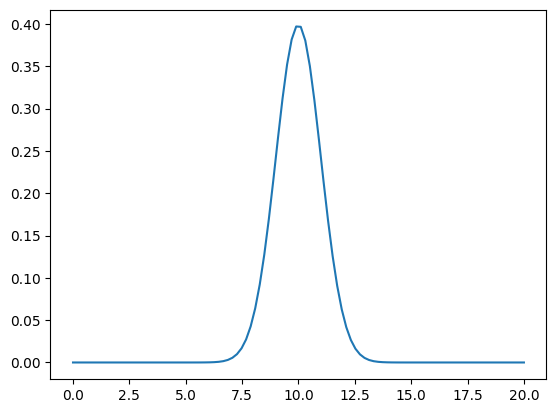

In [23]:
# plot density of den
radius = 10
sigma = 1
x = np.linspace(0.01, radius*2, 100)
nc = (radius/sigma)**2
df = 1
y = den(x, df, nc)
plt.plot(x, y)

print(np.sum(y)*(x[1]-x[0]))



In [28]:
def ln_gamma(x, y, params):  
    """ Logarithm of joint intensity function"""
    # get parameters
    lam_gamma = params['lam_gamma']
    scale = params['scale']
    radius = params['radius']
    area = params['area']


    # compute log of joint intensity (we start by zero)
    lxy = 0

    # log density of first point
    lxy -= np.log(area)

    # second point conditioned on first in then computed in polar coordinates

    # account for change of variables to polar in 2d
    dist = np.sum((x-y)**2, axis=-1)
    dist = np.sqrt(dist)
    lxy -= np.log(dist)

    # compute log of joint intensity
    nc = (radius/scale)**2
    df = 2

    # distributes as non central chi (without square)
    v = dist/scale

    # accaunt for change of variables given by division by scale
    lxy -= np.log(scale)

    # compute log of non central chi squared
    lxy += log_noncentral_chi_pdf(v, df, nc)

    # random direction
    lxy -= np.log(2*np.pi)

    # for general case:
    # lxy -= log(np.pi**(df/2)/np.math.factorial(int(df/2+1)))
    
    # total intensity 
    lxy += np.log(lam_gamma)

    return lxy


# plot this function for x = [0, 0] and different ys in R^2
x = np.array([0, 0])    
y = np.array([0, 2])
params = true_params
def f(y, params):
    x = np.array([0, 0])
    return np.exp(ln_gamma(x, y, params))
print(ln_gamma(x, y, params))

-19595.140697227882


In [29]:
print(true_params)

{'lam_gamma': 30, 'lam_mu': 30, 'lam_nu': 30, 'scale': 0.01, 'radius': 0.02, 'area': 1}


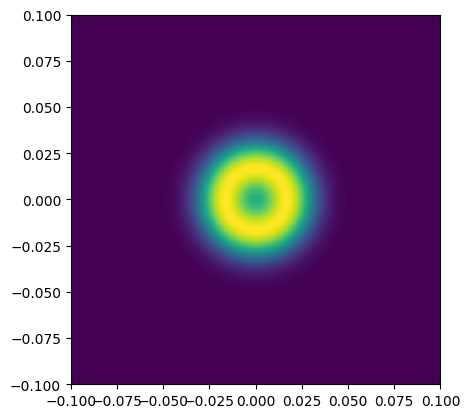

In [30]:
l = 0.1
y0 = np.linspace(-l, l, 300)
y1 = np.linspace(-l, l, 300)
Y0, Y1 = np.meshgrid(y0, y1)
Z = np.zeros_like(Y0)
for i in range(len(y0)):
    for j in range(len(y1)):
        y = np.array([y0[i], y1[j]])
        Z[i, j] = f(y, params)
plt.imshow(Z.T, extent=(-l, l, -l, l))
plt.show()

In [31]:
# check if area sums up to 1
print(np.sum(Z)*(y0[1]-y0[0])*(y1[1]-y1[0]))

29.999999999999435


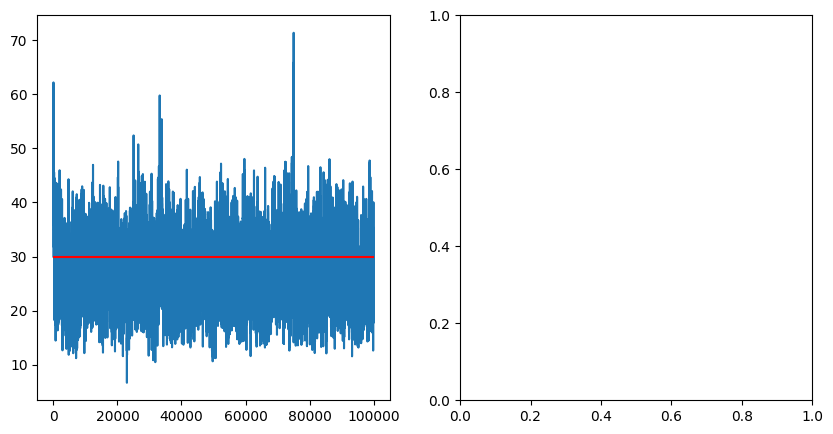

In [32]:
# plot lam_nu trajectory

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
lam_nu_traj = [params["lam_nu"] for params in chain.param_trajectory]
ax[0].plot(np.arange(len(lam_nu_traj)), lam_nu_traj)
ax[0].hlines(y=true_params["lam_nu"], xmin=0, xmax=len(lam_nu_traj), color="red")



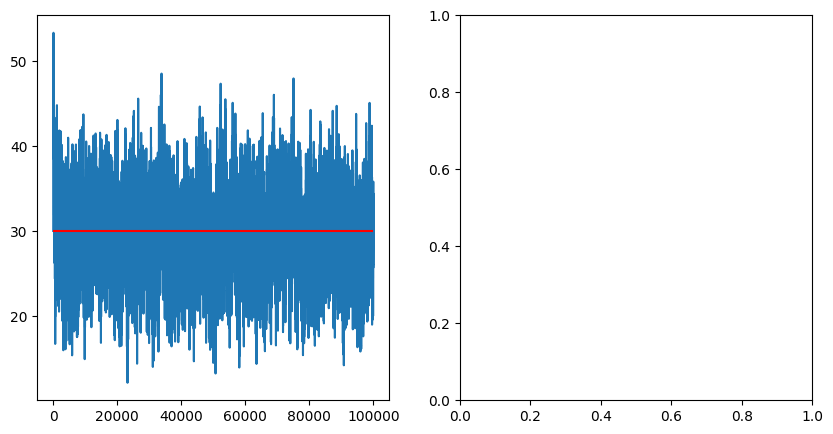

In [33]:
# plot lam_mu trajectory

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
lam_mu_traj = [params["lam_mu"] for params in chain.param_trajectory]
ax[0].plot(np.arange(len(lam_mu_traj)), lam_mu_traj)
ax[0].hlines(y=true_params["lam_mu"], xmin=0, xmax=len(lam_mu_traj), color="red")